<a href="https://colab.research.google.com/github/nasreenpmohsin/17FlowerCalssification-VGG/blob/main/17FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for file editing
import shutil # for console commands

In [9]:
import tarfile
#import urllib
import urllib.request
def download(filename, source_url, work_directory):
    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath): # check if file exists; if not, download
        print("Downloading file, Please wait...")
        filepath, _ = urllib.request.urlretrieve(source_url + filename, # this is a function to download files
                                                 filepath)
        statinfo = os.stat(filepath)
        print(('Succesfully downloaded', filename, statinfo.st_size, 'bytes.'))
        untar(filepath,work_directory)
    return filepath
# extract function
def untar(fname,path="17category-flowers"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path="17category-flowers", members=jpg_files(tar))
    tar.close()
    if path is "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to ",  path)
#only extract jpg files
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo

In [10]:
download("17flowers.tgz", "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/","17category-flowers")

('Succesfully downloaded', '17flowers.tgz', 60270631, 'bytes.')
File Extracted in to  17category-flowers


'17category-flowers/17flowers.tgz'

In [12]:
os.listdir("/content/17category-flowers")

['17flowers.tgz', 'jpg']

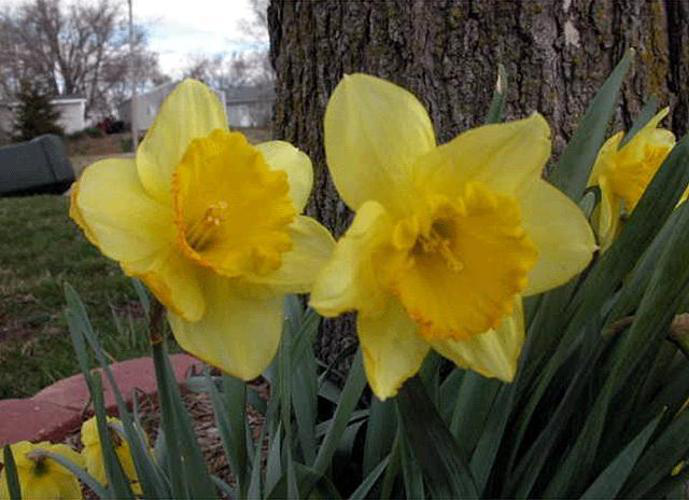

In [14]:
from PIL import Image #show one example of image
Image.open("/content/17category-flowers/jpg/image_0001.jpg")

In [26]:
#all images are loaded as np arrays
images=[]
labels=[]
total=1361
width=230
height=230
j=1
for i in range(1, total): 
    fname="/content/17category-flowers/jpg/image_"    
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    img=Image.open(fpath).resize((width,height)) # resize to width x height for modelling
    img = np.asarray(img, dtype='float32')
    images.append(img)
    labels.append(j) #labels are created as well
    if i%80==0: j+=1


In [27]:
"""print(len(images[0]))
print(len(images[1]))
print(len(images[2]))
print(len(images[3]))"""
images = np.asarray(images)#.reshape(1360,width,height,3) # all of the images are converted to np array of (1360,width,height,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

230
230
230
230


(1360, 230, 230, 3)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


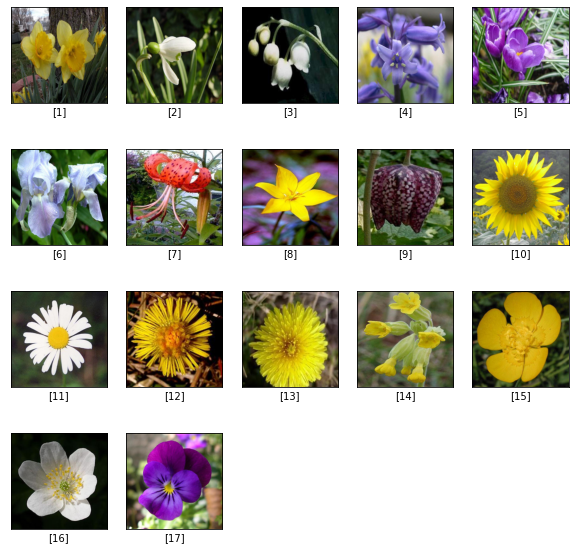

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) # plot 1 image from 
for i in range(17):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i*80]/255, cmap=plt.cm.binary)
    plt.xlabel(labels[i*80])

In [35]:
# split data into training and test
from sklearn.model_selection import train_test_split 
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size = 0.8, random_state =  42)

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
normalized_train_images = pd.DataFrame(StandardScaler().fit_transform(train_images), columns = train_images.columns)
normalized_test_images = pd.DataFrame(StandardScaler().fit_transform(test_images), columns = test_images.columns)


ValueError: ignored

In [37]:
print(normalized_train_images.shape)
print(normalized_test_images.shape)

(951, 230, 230, 3)
(409, 230, 230, 3)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

BATCH_SIZE = 32

torch_train_images = torch.from_numpy(train_images).type(torch.LongTensor)
torch_train_labels = torch.from_numpy(train_labels).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_test_images = torch.from_numpy(test_images).type(torch.LongTensor)
torch_test_labels = torch.from_numpy(test_labels).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_train_images,torch_train_labels)
test = torch.utils.data.TensorDataset(torch_test_images,torch_test_labels)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)